In [1]:
# notebooks/07_deep_dive_analysis.ipynb

import pandas as pd
from neo4j import GraphDatabase
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# --- Connect to Neo4j ---
load_dotenv()
URI = os.getenv("NEO4J_URI")
AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
driver = GraphDatabase.driver(URI, auth=AUTH)

# --- Helper Function ---
def query_to_dataframe(driver, query, **params):
    """
    This function executes a Cypher query and returns the results as a pandas DataFrame.
    """
    with driver.session() as session:
        result = session.run(query, **params)
        return pd.DataFrame([r.data() for r in result])

print("Setup complete. Connected to Neo4j.")

Setup complete. Connected to Neo4j.


## 1. Deep Dive on Top Performers
This section answers the follow-up questions from the macro analysis by programmatically investigating the top 5 most influential authors and papers.

In [2]:
# First, get the names of the top 5 influential authors by in-corpus citations
top_authors_query = """
MATCH (author:Author)-[:AUTHORED]->(paper:Paper)<-[:CITES]-(citingPaper:Paper)
RETURN author.name as author, count(citingPaper) as in_corpus_citations
ORDER BY in_corpus_citations DESC
LIMIT 5
"""
top_authors_df = query_to_dataframe(driver, top_authors_query)
top_author_names = top_authors_df['author'].tolist()

# Now, loop through them and find their disciplinary focus
print("Analyzing the disciplinary focus of the top 5 influential authors...")
for author_name in top_author_names:
    author_discipline_query = f"""
    MATCH (a:Author {{name: "{author_name}"}})-[:AUTHORED]->(p:Paper)-[:HAS_FIELD]->(f:FieldOfStudy)
    RETURN f.name as field_of_study, count(p) as paper_count
    ORDER BY paper_count DESC
    """
    print(f"\n--- Disciplinary Focus for {author_name} ---")
    author_discipline_df = query_to_dataframe(driver, author_discipline_query)
    display(author_discipline_df)

Analyzing the disciplinary focus of the top 5 influential authors...

--- Disciplinary Focus for Renzhi Lu ---


,field_of_study,paper_count
0,Computer Science,7



--- Disciplinary Focus for S. Hong ---


,field_of_study,paper_count
0,Computer Science,6



--- Disciplinary Focus for B. Claessens ---


,field_of_study,paper_count
0,Computer Science,10
1,Engineering,5
2,Mathematics,3



--- Disciplinary Focus for Hepeng Li ---


,field_of_study,paper_count
0,Computer Science,5



--- Disciplinary Focus for Zhiqiang Wan ---


,field_of_study,paper_count
0,Computer Science,5


In [3]:
# First, get the titles of the top 5 most foundational (in-corpus cited) papers
top_papers_query = """
MATCH (p1:Paper)-[:CITES]->(p2:Paper)
RETURN p2.title AS foundational_paper, count(p1) AS citations_within_corpus
ORDER BY citations_within_corpus DESC
LIMIT 5
"""
top_papers_df = query_to_dataframe(driver, top_papers_query)
top_paper_titles = top_papers_df['foundational_paper'].tolist()

# Now, loop through them and analyze their authors' overall influence
print("\nAnalyzing the broader influence of the authors of top foundational papers...")
for paper_title in top_paper_titles:
    # This query needs to be handled carefully to escape quotes
    escaped_title = paper_title.replace('"', '\\"')
    influential_authors_followup_query = f"""
    MATCH (p:Paper {{title: "{escaped_title}"}})<-[:AUTHORED]-(a:Author)
    WITH COLLECT(a) AS influential_authors
    UNWIND influential_authors AS author
    MATCH (author)-[:AUTHORED]->(other_paper:Paper)<-[:CITES]-(citing_paper:Paper)
    WHERE other_paper.title <> "{escaped_title}"
    RETURN author.name AS author, count(citing_paper) AS other_in_corpus_citations
    ORDER BY other_in_corpus_citations DESC
    """
    print(f"\n--- Author Influence from paper: '{paper_title[:50]}...' ---")
    author_influence_df = query_to_dataframe(driver, influential_authors_followup_query)
    display(author_influence_df.head())


Analyzing the broader influence of the authors of top foundational papers...

--- Author Influence from paper: 'Model-Free Real-Time EV Charging Scheduling Based ...' ---


,author,other_in_corpus_citations
0,Hepeng Li,1
1,Zhiqiang Wan,1
2,Haibo He,1
3,D. Prokhorov,1



--- Author Influence from paper: 'Reinforcement learning for demand response: A revi...' ---


,author,other_in_corpus_citations
0,José R. Vázquez-Canteli,4
1,Z. Nagy,4



--- Author Influence from paper: 'Reinforcement Learning-Based Plug-in Electric Vehi...' ---


,author,other_in_corpus_citations
0,V. Koivunen,2
1,A. Chiş,2
2,J. Lundén,2



--- Author Influence from paper: 'Incentive-based demand response for smart grid wit...' ---


,author,other_in_corpus_citations
0,Renzhi Lu,45
1,S. Hong,38



--- Author Influence from paper: 'Optimal Demand Response Using Device-Based Reinfor...' ---


""


## 2. Temporal Analysis
This analysis visualizes the volume of publications per year for each of our original search queries. This helps identify which research topics are mature versus which are new and emerging.


Calculating publication timeline by query topic...


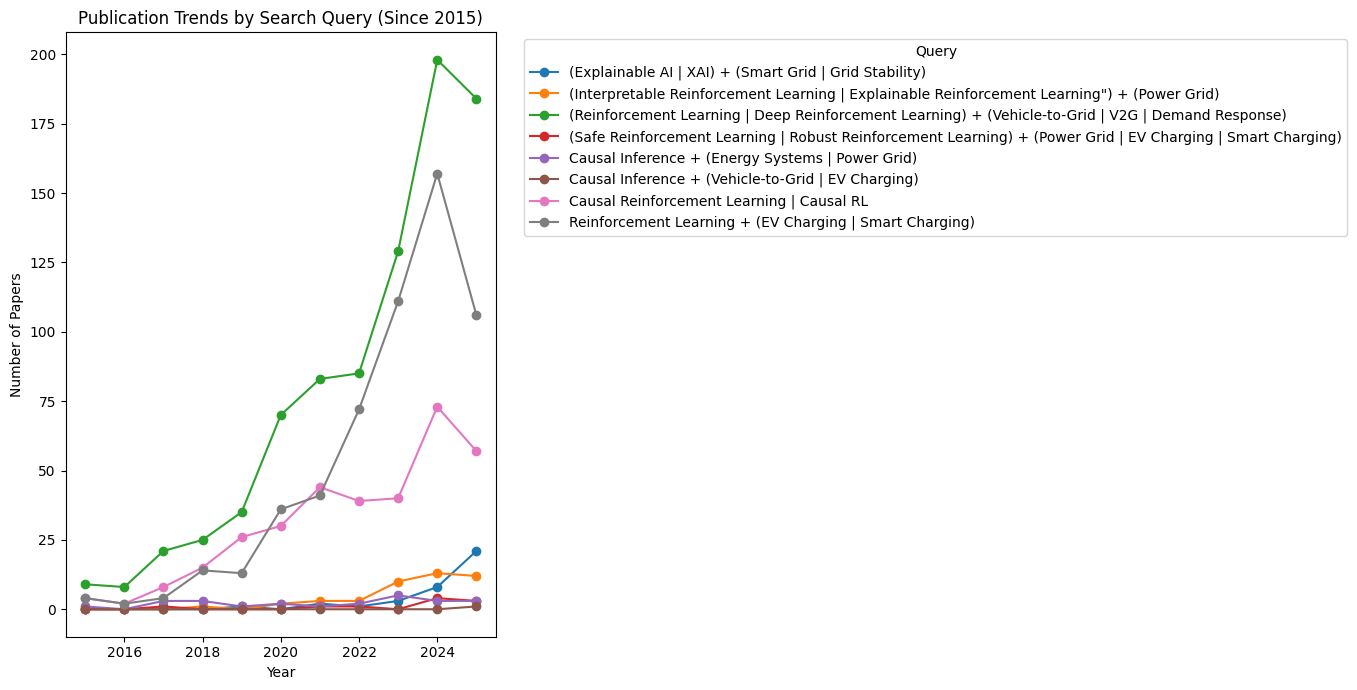

In [4]:
# This query gets the paper count per year for each of our original search queries.
timeline_by_query = """
MATCH (q:Query)<-[:FOUND_BY]-(p:Paper)
WHERE p.year IS NOT NULL AND p.year >= 2015
RETURN p.year AS year, q.name AS query, count(p) AS paper_count
ORDER BY year, query
"""
print("\nCalculating publication timeline by query topic...")
timeline_by_query_df = query_to_dataframe(driver, timeline_by_query)

# Use pandas pivot to create a plottable structure
timeline_pivot = timeline_by_query_df.pivot_table(index='year', columns='query', values='paper_count').fillna(0)

# Plotting the multi-line chart
fig, ax = plt.subplots(figsize=(14, 7))
timeline_pivot.plot(kind='line', ax=ax, marker='o')
ax.set_title('Publication Trends by Search Query (Since 2015)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Papers')
ax.legend(title='Query', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()